# 5. 기계 번역(Neural Machine Translation)

이번 챕터에서는 기계 번역에 쓰이는 seq2seq 모델과 이를 위한 어텐션 메커니즘에 대해서 학습합니다.

## 1) 시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)

시퀀스-투-시퀀스(Sequence-to-Sequence)는 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 다양한 분야에서 사용되는 모델입니다. 예를 들어 챗봇(Chatbot)과 기계 번역(Machine Translation)이 그러한 대표적인 예인데, 입력 시퀀스와 출력 시퀀스를 각각 질문과 대답으로 구성하면 챗봇으로 만들 수 있고, 입력 시퀀스와 출력 시퀀스를 각각 입력 문장과 번역 문장으로 만들면 번역기로 만들 수 있습니다. 그 외에도 내용 요약(Text Summarization), STT(Speech to Text) 등에서 쓰일 수 있습니다.

이번 챕터에서는 기계 번역을 예제로 시퀀스-투-시퀀스를 설명합니다. 앞으로는 줄여서 seq2seq이라는 이름으로 설명하겠습니다. seq2seq에 대한 구조를 이해하고, 케라스(keras)를 통해 직접 구현해봅시다.

### 1. 시퀀스-투-시퀀스(Sequence-to-Sequence)

seq2seq는 번역기에서 대표적으로 사용되는 모델입니다. 앞으로의 설명 방식은 내부가 보이지 않는 커다란 블랙 박스에서 점차적으로 확대해가는 방식으로 설명합니다. 참고로 여기서 설명하는 내용의 대부분은 RNN 챕터에서 언급한 내용들입니다. 단지 이것을 가지고 어떻게 조립했느냐에 따라서 seq2seq라는 구조가 만들어집니다.

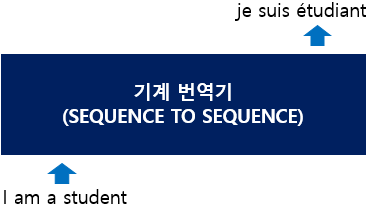

위의 그림은 seq2seq 모델로 만들어진 번역기가 'I am a student'라는 영어 문장을 입력받아서, 'je suis étudiant'라는 프랑스 문장을 출력하는 모습을 보여줍니다. 그렇다면, seq2seq 모델 내부의 모습은 어떻게 구성되었을까요?

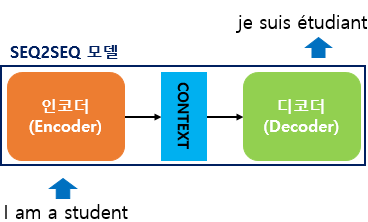

seq2seq는 크게 두 개로 구성된 아키텍처로 구성되는데, 바로 인코더와 디코더입니다. 인코더는 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터로 만드는데, 이를 컨텍스트 벡터(context vector)라고 합니다. 입력 문장의 정보가 하나의 컨텍스트 벡터로 모두 압축되면 인코더는 컨텍스트 벡터를 디코더로 전송합니다. 디코더는 컨텍스트 벡터를 받아서 번역된 단어를 한 개씩 순차적으로 출력합니다.

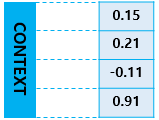

컨텍스트 벡터에 대해서는 뒤에서 다시 언급하겠습니다. 위의 그림에서는 컨텍스트 벡터를 4의 사이즈로 표현하였지만, 실제 현업에서 사용되는 seq2seq 모델에서는 보통 수백 이상의 차원을 갖고있습니다. 이제 인코더와 디코더의 내부를 좀 더 확대해보겠습니다.

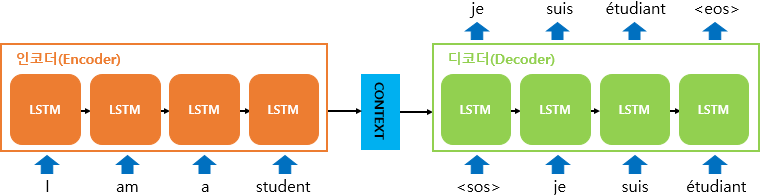

인코더 아키텍처와 디코더 아키텍처의 내부는 사실 두 개의 RNN 아키텍처 입니다. 입력 문장을 받는 RNN 셀을 인코더라고 하고, 출력 문장을 출력하는 RNN 셀을 디코더라고 합니다. 이번 챕터에서는 인코더의 RNN 셀을 주황색으로, 디코더의 RNN 셀을 초록색으로 표현합니다. 물론, 성능 문제로 인해 실제로는 바닐라 RNN이 아니라 LSTM 셀 또는 GRU 셀들로 구성됩니다. 우선 인코더를 자세히보면, 입력 문장은 단어 토큰화를 통해서 단어 단위로 쪼개지고 단어 토큰 각각은 RNN 셀의 각 시점의 입력이 됩니다. 인코더 RNN 셀은 모든 단어를 입력받은 뒤에 인코더 RNN 셀의 마지막 시점의 은닉 상태를 디코더 RNN 셀로 넘겨주는데 이를 컨텍스트 벡터라고 합니다. 컨텍스트 벡터는 디코더 RNN 셀의 첫번째 은닉 상태로 사용됩니다.

디코더는 기본적으로 RNNLM(RNN Language Model)입니다. 그래서 RNNLM의 개념을 기억하고 있다면 좀 더 이해하기 쉽지만, 기억하지 못 하더라도 다시 처음부터 설명할 것이므로 상관없습니다.

디코더는 초기 입력으로 문장의 시작을 의미하는 심볼 <sos>가 들어갑니다. 디코더는 <sos>가 입력되면, 다음에 등장할 확률이 높은 단어를 예측합니다. 첫번째 시점(time step)의 디코더 RNN 셀은 다음에 등장할 단어로 je를 예측하였습니다. 첫번째 시점의 디코더 RNN 셀은 예측된 단어 je를 다음 시점의 RNN 셀의 입력으로 입력합니다. 그리고 두번째 시점의 디코더 RNN 셀은 입력된 단어 je로부터 다시 다음에 올 단어인 suis를 예측하고, 또 다시 이것을 다음 시점의 RNN 셀의 입력으로 보냅니다. 디코더는 이런 식으로 기본적으로 다음에 올 단어를 예측하고, 그 예측한 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복합니다. 이 행위는 문장의 끝을 의미하는 심볼인 <eos>가 다음 단어로 예측될 때까지 반복됩니다. 지금 설명하는 것은 테스트 과정 동안의 이야기입니다.

seq2seq는 훈련 과정과 테스트 과정(또는 실제 번역기를 사람이 쓸 때)의 작동 방식이 조금 다릅니다. 훈련 과정에서는 디코더에게 인코더가 보낸 컨텍스트 벡터와 실제 정답인 상황인 <sos> je suis étudiant를 입력 받았을 때, je suis étudiant <eos>가 나와야 된다고 정답을 알려주면서 훈련합니다. 이에 대해서는 뒤에 교사 강요(teacher forcing)를 설명하면서 다시 언급하겠습니다. 반면 테스트 과정에서는 앞서 설명한 과정과 같이 디코더는 오직 컨텍스트 벡터와 <sos>만을 입력으로 받은 후에 다음에 올 단어를 예측하고, 그 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복합니다. 즉, 앞서 설명한 과정과 위의 그림은 테스트 과정에 해당됩니다. 이번에는 입, 출력에 쓰이는 단어 토큰들이 있는 부분을 좀 더 확대해보겠습니다.

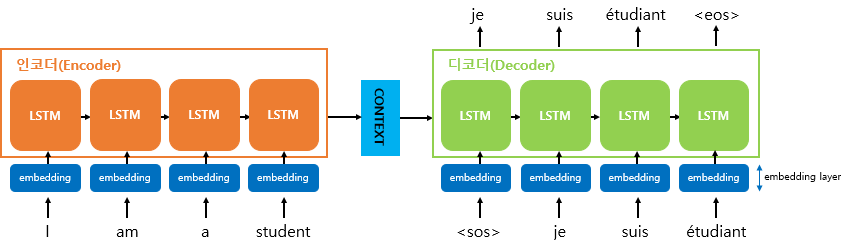

기계는 텍스트보다 숫자를 잘 처리합니다. 그리고 자연어 처리에서 텍스트를 벡터로 바꾸는 방법으로 워드 임베딩(10챕터 참고)이 사용된다고 설명한 바 있습니다. 즉, seq2seq에서 사용되는 모든 단어들은 워드 임베딩을 통해 임베딩 벡터로서 표현된 임베딩 벡터입니다. 위 그림은 모든 단어에 대해서 임베딩 과정을 거치게 하는 단계인 임베딩 층(embedding layer)의 모습을 보여줍니다.

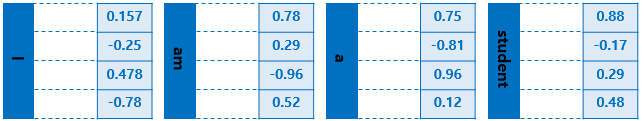

예를 들어 I, am, a, student라는 단어들에 대한 임베딩 벡터는 위와 같은 모습을 가집니다. 여기서는 그림으로 표현하고자 사이즈를 4로 하였지만, 보통 실제 임베딩 벡터는 수백 개의 차원을 가질 수 있습니다. 이제 RNN 셀에 대해서 확대해보겠습니다.

이미 RNN에 대해서 배운 적이 있지만, 다시 복습을 해보도록 하겠습니다. 하나의 RNN 셀은 각각의 시점(time step)마다 두 개의 입력을 받습니다. (이해가 되지 않는다면, RNN 챕터를 다시 참고하세요.)

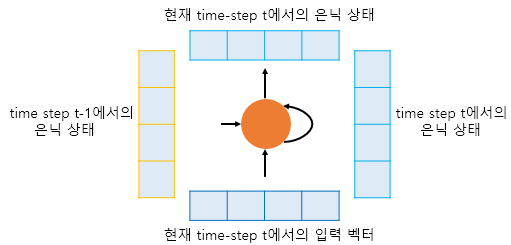

현재 시점(time step)을 t라고 할 때, RNN 셀은 t-1에서의 은닉 상태와 t에서의 입력 벡터를 입력으로 받고, t에서의 은닉 상태를 만듭니다. 이때 t에서의 은닉 상태는 바로 위에 또 다른 은닉층이나 출력층이 존재할 경우에는 위의 층으로 보내거나, 필요없으면 값을 무시할 수 있습니다. 그리고 RNN 셀은 다음 시점에 해당하는 t+1의 RNN 셀의 입력으로 현재 t에서의 은닉 상태를 입력으로 보냅니다.

RNN 챕터에서도 언급했지만, 이런 구조에서 현재 시점 t에서의 은닉 상태는 과거 시점의 동일한 RNN 셀에서의 모든 은닉 상태의 값들의 영향을 누적해서 받아온 값이라고 할 수 있습니다. 그렇기 때문에 앞서 우리가 언급했던 컨텍스트 벡터는 사실 인코더에서의 마지막 RNN 셀의 은닉 상태값을 말하는 것이며, 이는 입력 문장의 모든 단어 토큰들의 정보를 요약해서 담고있다고 할 수 있습니다.

디코더는 인코더의 마지막 RNN 셀의 은닉 상태인 컨텍스트 벡터를 첫번째 은닉 상태의 값으로 사용합니다. 디코더의 첫번째 RNN 셀은 이 첫번째 은닉 상태의 값과, 현재 t에서의 입력값인 <sos>로부터, 다음에 등장할 단어를 예측합니다. 그리고 이 예측된 단어는 다음 시점인 t+1 RNN에서의 입력값이 되고, 이 t+1에서의 RNN 또한 이 입력값과 t에서의 은닉 상태로부터 t+1에서의 출력 벡터. 즉, 또 다시 다음에 등장할 단어를 예측하게 될 것입니다. 이제 디코더가 다음에 등장할 단어를 예측하는 부분을 확대해보도록 하겠습니다.

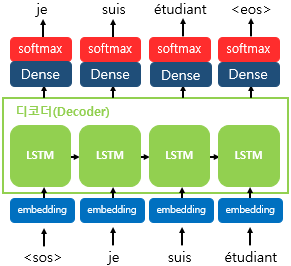

출력 단어로 나올 수 있는 단어들은 다양한 단어들이 있습니다. seq2seq 모델은 선택될 수 있는 모든 단어들로부터 하나의 단어를 골라서 예측해야 합니다. 이를 예측하기 위해서 쓸 수 있는 함수로는 뭐가 있을까요? 바로 소프트맥스 함수입니다. 디코더에서 각 시점(time step)의 RNN 셀에서 출력 벡터가 나오면, 해당 벡터는 소프트맥스 함수를 통해 출력 시퀀스의 각 단어별 확률값을 반환하고, 디코더는 출력 단어를 결정합니다.

지금까지 가장 기본적인 seq2seq에 대해서 배워보았습니다. 사실 seq2seq는 어떻게 구현하느냐에 따라서 충분히 더 복잡해질 수 있습니다. 컨텍스트 벡터를 디코더의 초기 은닉 상태로만 사용할 수도 있고, 거기서 더 나아가 컨텍스트 벡터를 디코더가 단어를 예측하는 매 시점마다 하나의 입력으로 사용할 수도 있으며 거기서 더 나아가면 어텐션 메커니즘이라는 방법을 통해 지금 알고있는 컨텍스트 벡터보다 더욱 문맥을 반영할 수 있는 컨텍스트 벡터를 구하여 매 시점마다 하나의 입력으로 사용할 수도 있습니다. 어텐션 메커니즘에 대해서는 다음 챕터에서 배웁니다.

### 2. 글자 레벨 기계 번역기(Character-Level Neural Machine Translation) 구현하기

이제 seq2seq를 이용해서 기계 번역기를 만들어보도록 하겠습니다. 시작하기에 앞서 참고하면 좋은 게시물을 소개합니다. 인터넷에 케라스로 seq2seq를 구현하는 많은 유사 예제들이 나와있지만 대부분은 케라스 개발자 프랑수아 숄레의 블로그의 유명 게시물인 'sequence-to-sequence 10분만에 이해하기'가 원본입니다. 이번 실습 또한 해당 게시물의 예제에 많이 영향받았습니다.

해당 게시물 링크 : https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

실제 성능이 좋은 기계 번역기를 구현하려면 정말 방대한 데이터가 필요하므로 여기서는 방금 배운 seq2seq를 실습해보는 수준에서 아주 간단한 기계 번역기를 구축해보도록 하겠습니다. 기계 번역기를 훈련시키기 위해서는 훈련 데이터로 병렬 코퍼스(parallel corpus)가 필요합니다. 병렬 코퍼스란, 두 개 이상의 언어가 병렬적으로 구성된 코퍼스를 의미합니다.

다운로드 링크 : http://www.manythings.org/anki

이번 실습에서는 한국어-영어 병렬 코퍼스인 kor-eng.zip 파일을 사용할 겁니다. 위의 링크에서 해당 파일을 다운받으시면 됩니다. 해당 파일의 압축을 풀면 kor.txt라는 파일이 있는데 이 파일이 이번 실습에서 사용할 파일입니다.

#### 1) 병렬 코퍼스 데이터에 대한 이해와 전처리

우선 병렬 코퍼스 데이터에 대한 이해를 해보겠습니다. 병렬 데이터라고 하면 앞서 수행한 태깅 작업의 데이터를 생각할 수 있지만, 앞서 수행한 태깅 작업의 병렬 데이터와 seq2seq가 사용하는 병렬 데이터는 성격이 조금 다릅니다. 태깅 작업의 병렬 데이터는 쌍이 되는 모든 데이터가 길이가 같았지만 여기서는 쌍이 된다고 해서 길이가 같지않습니다.

실제 번역기를 생각해보면 구글 번역기에 '나는 학생이다.'라는 토큰의 개수가 2인 문장을 넣었을 때 'I am a student.'라는 토큰의 개수가 4인 문장이 나오는 것과 같은 이치입니다. seq2seq는 기본적으로 입력 시퀀스와 출력 시퀀스의 길이가 다를 수 있다고 가정합니다. 지금은 기계 번역기가 예제지만 seq2seq의 또 다른 유명한 예제 중 하나인 챗봇을 만든다고 가정해보면, 대답의 길이가 질문의 길이와 항상 똑같아야 한다고하면 그 또한 이상합니다.

Watch me.           Regardez-moi !  
  
  
여기서 사용할 kor.txt 데이터는 위와 같이 왼쪽의 영어 문장과 오른쪽의 한국어 문장 사이에 탭으로 구분되는 구조가 하나의 샘플입니다. 그리고 이와 같은 형식의 약 3600개의 병렬 문장 샘플을 포함하고 있습니다. 해당 데이터를 읽고 전처리를 진행해보겠습니다. 앞으로의 코드에서 src는 source의 줄임말로 입력 문장을 나타내며, tar는 target의 줄임말로 번역하고자 하는 문장을 나타냅니다.

In [1]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/kor-eng.zip'
filename = 'kor-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [11]:
lines= pd.read_csv('kor.txt', names=['src', 'tar'], sep='\t', index_col =False)
len(lines)

3648

전체 샘플의 개수는 총 약 3640개입니다.

In [12]:
lines.head(10)

,src,tar
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?
5,Wow!,우와!
6,Fire!,쏴!
7,Help!,도와줘!
8,Jump!,점프!
9,Jump.,점프해.


위의 테이블은 랜덤으로 선택된 10개의 샘플을 보여줍니다. 번역 문장에 해당되는 프랑스어 데이터는 앞서 배웠듯이 시작을 의미하는 심볼 sos과 종료를 의미하는 심볼 eos을 넣어주어야 합니다. 여기서는 sos와 eos 대신 '\t'를 시작 심볼, '\n'을 종료 심볼로 간주하여 추가하고 다시 데이터를 출력해보겠습니다.

In [13]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

,src,tar
2389,We'll get there in three hours.,\t 3시간 안에 거기에 도착할 겁니다. \n
1042,Tom held his breath.,\t 톰은 숨을 참았어. \n
830,I taught Tom golf.,\t 난 톰한테 골프를 가르쳤어. \n
2217,I don't like talking with Tom.,\t 난 톰이랑 대화하는 걸 좋아하지 않아. \n
2322,How many children were injured?,\t 아이들은 몇 명 다쳤어? \n
1327,I'm just doing my best.,\t 난 그저 최선을 다하고 있을 뿐이다. \n
1397,You're quite forgetful.,\t 너 건망증이 좀 있구나. \n
119,Dogs bark.,\t 개가 짖네. \n
2340,I wish I'd married another man.,\t 다른 남자와 결혼했다면 좋았을 텐데. \n
2274,Tom is wearing a baseball cap.,\t 톰은 야구 모자를 쓰고 있어. \n


랜덤으로 10개의 샘플을 선택하여 출력하였습니다. 한국어 데이터에서 시작 심볼과 종료 심볼이 추가된 것을 볼 수 있습니다. 이제 글자 집합을 생성해보겠습니다. 단어 집합이 아니라 글자 집합이라고 하는 이유는 토큰 단위가 단어가 아니라 글자이기 때문입니다.

In [14]:
# 글자 집합 구축
src_vocab=set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)

tar_vocab=set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

글자 집합의 크기를 보겠습니다.

In [15]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print(src_vocab_size)
print(tar_vocab_size)

75
912


영어와 한국어는 각각 약 75개와 911개의 글자가 존재합니다. 이 중에서 인덱스를 임의로 부여하여 일부만 출력해봅시다. 현 상태에서 인덱스를 사용하려고 하면 에러가 납니다. 하지만 정렬하여 순서를 정해준 뒤에 인덱스를 사용하여 출력해주면 됩니다.

In [16]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°', 'ï']
['간', '갇', '갈', '감', '갑', '값', '갔', '강', '갖', '같', '개', '객', '갰', '걀', '걔', '거', '걱', '건', '걷', '걸', '검', '겁', '것', '게', '겐', '겠', '겨', '격', '겪', '견']


글자 집합에 글자 단위로 저장된 것을 확인할 수 있습니다. 이제 각 글자에 인덱스를 부여하겠습니다.

In [19]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, "'": 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'Y': 46, 'a': 47, 'b': 48, 'c': 49, 'd': 50, 'e': 51, 'f': 52, 'g': 53, 'h': 54, 'i': 55, 'j': 56, 'k': 57, 'l': 58, 'm': 59, 'n': 60, 'o': 61, 'p': 62, 'q': 63, 'r': 64, 's': 65, 't': 66, 'u': 67, 'v': 68, 'w': 69, 'x': 70, 'y': 71, 'z': 72, '°': 73, 'ï': 74}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '%': 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, '?': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'H': 29, 'M': 30, 'N': 31, 'T': 32, 'a': 33, 'd': 34, 'h': 35, 'i': 36, 'm': 37, 'o': 38, 'p': 3

이제 인덱스가 부여된 글자 집합으로부터 갖고있는 훈련 데이터에 정수 인코딩을 수행하겠습니다. 우선 인코더의 입력이 될 영어 문장 샘플에 대해서 정수 인코딩을 수행해보고, 5개의 샘플을 출력해봅시다.

In [20]:
encoder_input = []
for line in lines.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
      temp_X.append(src_to_index[w]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)
print(encoder_input[:5])

[[29, 61, 9], [30, 55, 9], [40, 67, 60, 2], [40, 67, 60, 9], [45, 54, 61, 22]]


정수 인코딩이 수행된 것을 볼 수 있습니다. 이제 디코더의 입력이 될 한국어 데이터에 대해서 정수 인코딩을 수행해보겠습니다.

In [22]:
decoder_input = []
for line in lines.tar:
    temp_X = []
    for w in line:
      temp_X.append(tar_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

[[1, 3, 44, 11, 3, 2], [1, 3, 548, 195, 11, 3, 2], [1, 3, 288, 570, 4, 3, 2], [1, 3, 288, 570, 11, 3, 2], [1, 3, 206, 96, 24, 3, 2]]


정상적으로 정수 인코딩이 수행된 것을 볼 수 있습니다. 아직 정수 인코딩을 수행해야 할 데이터가 하나 더 남았습니다. 디코더의 예측값과 비교하기 위한 실제값이 필요합니다. 그런데 이 실제값에는 시작 심볼에 해당되는 <sos>가 있을 필요가 없습니다. 이해가 되지 않는다면 이전 페이지의 그림으로 돌아가 Dense와 Softmax 위에 있는 단어들을 다시 보시기 바랍니다. 그래서 이번에는 정수 인코딩 과정에서 <sos>를 제거합니다. 즉, 모든 프랑스어 문장의 맨 앞에 붙어있는 '\t'를 제거하도록 합니다.

In [23]:
decoder_target = []
for line in lines.tar:
    t=0
    temp_X = []
    for w in line:
      if t>0:
        temp_X.append(tar_to_index[w])
      t=t+1
    decoder_target.append(temp_X)
print(decoder_target[:5])

[[3, 44, 11, 3, 2], [3, 548, 195, 11, 3, 2], [3, 288, 570, 4, 3, 2], [3, 288, 570, 11, 3, 2], [3, 206, 96, 24, 3, 2]]


앞서 먼저 만들었던 디코더의 입력값에 해당되는 decoder_input 데이터와 비교하면 decoder_input에서는 모든 문장의 앞에 붙어있던 숫자 1이 decoder_target에서는 제거된 것을 볼 수 있습니다. '\t'가 인덱스가 1이므로 정상적으로 제거된 것입니다. 이제 모든 데이터에 대해서 정수 인덱스로 변경하였으니 패딩 작업을 수행하겠습니다. 패딩을 위해서 영어 문장과 한국어 문장 각각에 대해서 가장 길이가 긴 샘플의 길이를 알아보겠습니다.

In [24]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)

537
300


각각 537와 300의 길이를 가집니다. 이번 병렬 데이터는 영어와 한국어의 길이는 하나의 쌍이라고 하더라도 전부 다르므로 패딩을 할 때도 이 두 개의 데이터의 길이를 전부 동일하게 맞춰줄 필요는 없습니다. 영어 데이터는 영어 샘플들끼리, 한국어는 한국어 샘플들끼리 길이를 맞추어서 패딩하면 됩니다. 여기서는 가장 긴 샘플의 길이에 맞춰서 영어 데이터의 샘플은 전부 길이가 537가 되도록 패딩하고, 프랑스어 데이터의 샘플은 전부 길이가 300이 되도록 패딩합니다.

In [25]:
max_src_len //= 10
max_tar_len //= 10
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

이제 모든 값에 대해서 원-핫 인코딩을 수행합니다. 글자 단위 번역기므로 워드 임베딩은 별도로 사용되지 않으며, 예측값과의 오차 측정에 사용되는 실제값뿐만 아니라 입력값도 원-핫 벡터를 사용하겠습니다.

In [26]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

이제 데이터에 대한 전처리가 모두 끝났습니다. 본격적으로 seq2seq 모델을 설계해보겠습니다.

#### 2) 교사 강요(Teacher forcing)

모델을 설계하기 전에 혹시 의아한 점은 없으신가요? 현재 시점의 디코더 셀의 입력은 오직 이전 디코더 셀의 출력을 입력으로 받는다고 설명하였는데 decoder_input이 왜 필요할까요?

훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용할 겁니다. 그 이유는 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높고 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 합니다. 이런 상황이 반복되면 훈련 시간이 느려집니다. 만약 이 상황을 원하지 않는다면 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있습니다. 이와 같이 RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 합니다.

#### 3) seq2seq 기계 번역기 훈련시키기

이제 seq2seq 모델을 설계하고 교사 강요를 사용하여 훈련시켜보도록 하겠습니다.

In [27]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

In [28]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
encoder_states = [state_h, state_c]
# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.

인코더를 주목해보면 functional API를 사용한다는 것 외에는 앞서 다른 실습에서 본 LSTM 설계와 크게 다르지는 않습니다. 우선 LSTM의 은닉 상태 크기는 256으로 선택하였습니다. 인코더의 내부 상태를 디코더로 넘겨주어야 하기 때문에 return_state=True로 설정합니다. 이제 인코더에 입력을 넣으면 내부 상태를 리턴합니다.

LSTM에서 state_h, state_c를 리턴받는데, 이는 각각 LSTM 챕터에서 배운 은닉 상태와 셀 상태에 해당됩니다. 앞서 이론을 설명할 때는 셀 상태는 설명에서 생략하고 은닉 상태만 언급하였으나 사실 LSTM은 은닉 상태와 셀 상태라는 두 가지 상태를 가진다는 사실을 기억해야 합니다. 갑자기 어려워진 게 아닙니다. 단지 은닉 상태만 전달하는 게 아니라 은닉 상태와 셀 상태 두 가지를 전달한다고 생각하면 됩니다. 이 두 가지 상태를 encoder_states에 저장합니다. encoder_states를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달합니다. 이것이 앞서 배운 컨텍스트 벡터입니다.

In [30]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 합니다.
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

디코더는 인코더의 마지막 은닉 상태를 초기 은닉 상태로 사용합니다. 위에서 initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다. 또한 동일하게 디코더의 은닉 상태 크기도 256으로 주었습니다. 디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다. 그 후 출력층에 프랑스어의 단어 집합의 크기만큼 뉴런을 배치한 후 소프트맥스 함수를 사용하여 실제값과의 오차를 구합니다.

In [31]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=50, validation_split=0.2)

Epoch 1/50
46/46 [==============================] - 6s 70ms/step - loss: 3.6115 - val_loss: 4.0393
Epoch 2/50
46/46 [==============================] - 3s 58ms/step - loss: 2.4757 - val_loss: 4.1306
Epoch 3/50
46/46 [==============================] - 6s 128ms/step - loss: 2.2716 - val_loss: 3.8386
Epoch 4/50
46/46 [==============================] - 4s 91ms/step - loss: 2.1203 - val_loss: 3.8343
Epoch 5/50
46/46 [==============================] - 5s 106ms/step - loss: 1.9960 - val_loss: 3.3831
Epoch 6/50
46/46 [==============================] - 2s 48ms/step - loss: 1.8318 - val_loss: 3.5755
Epoch 7/50
46/46 [==============================] - 2s 48ms/step - loss: 1.9292 - val_loss: 3.3865
Epoch 8/50
46/46 [==============================] - 2s 49ms/step - loss: 1.6720 - val_loss: 3.3283
Epoch 9/50
46/46 [==============================] - 2s 48ms/step - loss: 1.5800 - val_loss: 3.3091
Epoch 10/50
46/46 [==============================] - 2s 52ms/step - loss: 1.5541 - val_loss: 3.2755
Epoch 1

입력으로는 인코더 입력과 디코더 입력이 들어가고, 디코더의 실제값인 decoder_target도 필요합니다. 배치 크기는 64로 하였으며 총 50 에포크를 학습합니다. 위에서 설정한 은닉 상태의 크기와 에포크 수는 실제로는 훈련 데이터에 과적합 상태를 불러옵니다. 중간부터 검증 데이터에 대한 오차인 val_loss의 값이 올라가는데, 사실 이번 실습에서는 주어진 데이터의 양과 태스크의 특성으로 인해 훈련 과정에서 훈련 데이터의 정확도와 과적합 방지라는 두 마리 토끼를 동시에 잡기에는 쉽지 않습니다. 여기서는 우선 seq2seq의 메커니즘과 짧은 문장과 긴 문장에 대한 성능 차이에 대한 확인을 중점으로 두고 훈련 데이터에 과적합 된 상태로 동작 단계로 넘어갑니다.

#### 4) seq2seq 기계 번역기 동작시키기

앞서 seq2seq는 훈련할 때와 동작할 때의 방식이 다르다고 언급한 바 있습니다. 이번에는 입력한 문장에 대해서 기계 번역을 하도록 모델을 조정하고 동작시켜보도록 하겠습니다.

전체적인 번역 동작 단계를 정리하면 아래와 같습니다.
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻습니다.
2. 상태와 <SOS>에 해당하는 '\t'를 디코더로 보냅니다.
3. 디코더가 <EOS>에 해당하는 '\n'이 나올 때까지 다음 문자를 예측하는 행동을 반복합니다.

In [32]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

우선 인코더를 정의합니다. encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용하는 것입니다. 이제 디코더를 설계해보겠습니다.

In [33]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
decoder_states = [state_h, state_c]
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [34]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

단어로부터 인덱스를 얻는 것이 아니라 인덱스로부터 단어를 얻을 수 있는 index_to_src와 index_to_tar를 만들었습니다.

In [35]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [36]:
import random
for i in range(10): # 입력 문장의 인덱스
    seq_index = random.randint(10,300)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][1:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Tom lied.
정답 문장:  톰이 거짓말했어. 
번역기가 번역한 문장:  톰이 웃었어. 
-----------------------------------
입력 문장: Cheer up!
정답 문장:  힘내! 
번역기가 번역한 문장:  그 사람들은 이겼어. 
-----------------------------------
입력 문장: Wonderful!
정답 문장:  멋져! 
번역기가 번역한 문장:  계속 땅 파고 있어봐. 
-----------------------------------
입력 문장: Keep quiet.
정답 문장:  조용히 해. 
번역기가 번역한 문장:  계속 조용해. 
-----------------------------------
입력 문장: Tom smiled.
정답 문장:  톰이 웃었어. 
번역기가 번역한 문장:  톰이 웃었어. 
-----------------------------------
입력 문장: Tom gasped.
정답 문장:  톰이 헉 소리를 냈어. 
번역기가 번역한 문장:  톰이 웃었어. 
-----------------------------------
입력 문장: Tom cried.
정답 문장:  톰은 울었어. 
번역기가 번역한 문장:  톰이 웃었어. 
-----------------------------------
입력 문장: Quiet down.
정답 문장:  조용히 해. 
번역기가 번역한 문장:  계속 말해. 
-----------------------------------
입력 문장: Who cares?
정답 문장:  누가 신경써? 
번역기가 번역한 문장:  우린 기억해. 
-----------------------------------
입력 문장: Tom agreed.
정답 문장:  톰이 동의했어. 
번역기가 번역한 문장:  톰이 웃었어. 


지금까지 글자 단위의 seq2seq를 구현하였습니다. 이전 모델들에 비해서 난이도가 확 높아져서 어려우셨을 수도 있었을텐데, 고생하셨습니다. 다음 챕터에서는 이번 챕터에서 배운 내용을 바탕으로 글자 단위에서 단어 단위로 확장해서 기계 번역기를 구현해보겠습니다.

## 2) Word-Level 번역기 만들기(Neural Machine Translation (seq2seq) Tutorial)

이전 챕터에서 seq2seq를 사용하여 글자 레벨(character-level)의 기계 번역기를 만들었습니다. 이번 챕터에서는 단어 레벨(Word-level)의 기계 번역기를 만들어봅시다. 모델 아키텍처는 이전 챕터와 거의 동일하지만, 단어 레벨을 수행하는만큼 추가적인 전처리와 임베딩 층(Embedding layer), 그리고 추가적인 후처리 작업이 필요합니다.

이번 챕터는 이전 챕터의 내용을 이해했다는 가정 하에 모델에 대한 설명을 자세하게 하지 않겠습니다.

### 1. 데이터 로드 및 전처리

필요한 도구들을 임포트합니다.

In [1]:
import numpy as np
import re
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import os
import unicodedata
import urllib3
import zipfile

데이터를 로드합니다. 데이터는 이전 챕터와 동일한 데이터를 사용할 예정입니다. 이에 데이터 구성에 대한 설명은 생략합니다.

In [2]:
num_samples = 33000

전처리 함수들을 구현합니다.

In [3]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [4]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

구현한 전처리 함수들을 임의의 문장을 입력으로 테스트해봅시다.

In [5]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"
print(preprocess_sentence(en_sent))
print(preprocess_sentence(fr_sent).encode('utf-8'))

have you had dinner ?
b'avez vous deja dine ?'


전체 데이터에서 3,000개의 샘플만 불러오되, 모든 전처리를 수행하는 함수를 만듭니다. 또한 훈련 과정에서 교사 강요(Teacher Forcing)을 사용할 예정이므로, 훈련 시 사용할 디코더의 입력 시퀀스와 실제값에 해당되는 출력 시퀀스를 따로 분리하여 저장합니다. 입력 시퀀스에는 시작을 의미하는 토큰인 sos를 추가하고, 출력 시퀀스에는 종료를 의미하는 토큰인 eos를 추가합니다.

In [6]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r", encoding='utf-8') as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

이렇게 얻은 3개의 데이터셋은 인코더의 입력, 디코더의 입력, 디코더의 실제값을 상위 5개 샘플만 출력해봅시다.

In [7]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

[['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
[['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
[['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


이제 케라스 토크나이저를 통해 단어 집합을 생성하고, 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정을 거칩니다.

In [8]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

이어서 패딩을 수행합니다.

In [9]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

이렇게 얻은 데이터의 크기(shape)를 확인합니다.

샘플은 총 3,000개 존재하며 영어 문장의 길이는 8, 프랑스어 문장의 길이는 16입니다. 단어 집합의 크기를 정의합니다.

In [10]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4571, 프랑스어 단어 집합의 크기 : 8090


단어 집합의 크기는 각각 4,571개와 8,090개입니다. 단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 이들은 훈련을 마치고 예측 과정과 실제값과 결과를 비교하는 경우에 사용됩니다.

In [11]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

이제 테스트 데이터를 분리할 차례입니다. 테스트 데이터를 분리하기 전에, 적절한 분포를 갖도록 데이터를 섞어주는 과정을 진행합니다. 이를 위해서 우선 순서가 섞인 정수 시퀀스 리스트를 만듭니다.

In [12]:
print(encoder_input.shape[0])
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

33000
[ 6051 23588    44 ...  5694 10300 23276]


이를 데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞이게 됩니다.

In [13]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

임의로 30,997번째 샘플을 출력해봅시다. 이때, decoder_input과 decoder_target은 데이터의 구조상으로 앞에 붙은 <sos> 토큰과 뒤에 붙은 <eos>을 제외하면 동일한 정수 시퀀스를 가져야하므로 이를 확인해주면 됩니다.

In [14]:
encoder_input[30997]

array([ 18,  22,  38, 117,   4,   0,   0,   0])

In [15]:
decoder_input[30997]

array([  2,  42,  43,  80, 500,   6,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

In [16]:
decoder_target[30997]

array([ 42,  43,  80, 500,   6,   3,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

저자의 경우 18, 5, 16, 173, 1이라는 동일 시퀀스를 확인했습니다. 이제 훈련 데이터의 10%를 테스트 데이터로 분리하겠습니다.

In [17]:
n_of_val = int(33000*0.1)
print(n_of_val)

3300


33,000개의 10%에 해당되는 3,300개의 데이터를 테스트 데이터로 사용합니다.

In [18]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

훈련 데이터와 테스트 데이터의 크기(shape)를 출력해봅시다.

In [19]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(29700, 8)
(29700, 16)
(29700, 16)
(3300, 8)
(3300, 16)
(3300, 16)


훈련 데이터의 샘플은 29,700개, 테스트 데이터의 샘플은 3,300개가 존재합니다. 이제 모델을 설계합니다.

### 2. 기계 번역기 만들기

모델 설계를 위해 필요한 도구들을 임포트합니다.

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

임베딩 벡터와 LSTM의 은닉 상태의 크기를 특정 크기로 고정하고자 합니다. 여기서는 50을 사용합니다.

In [21]:
latent_dim = 50

인코더를 설계합니다. Masking은 패딩 토큰인 숫자 0의 경우에는 연산을 제외하는 역할을 수행합니다.

In [22]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

이제 디코더를 설계합니다.

In [23]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

모델의 입력과 출력을 정의하므로서 모델을 정의합니다.

pydot 설치 방법

아나콘다 파워쉘 실행 후 <br>
conda install pydot

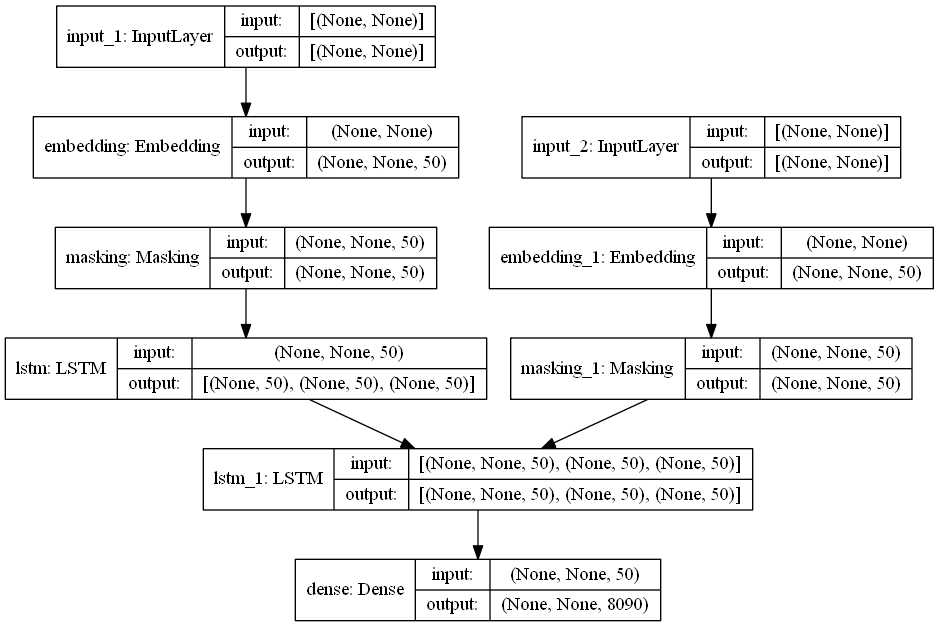

In [27]:
import keras
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

seq2seq의 디코더는 기본적으로 각각의 시점(timestep)에 대해서 다중 클래스 분류 문제를 풀고있습니다. 매 시점마다 프랑스어 단어 집합의 크기의 선택지에서 단어를 1개 선택하여 이를 이번 시점에서 예측한 단어로 택합니다. 다중 클래스 분류 문제이므로 위의 설계에서 출력층으로 소프트맥스 함수를 사용했습니다. 이 경우 손실 함수를 지금까지 categorical_crossentropy를 사용해왔습니다.

categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다. 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다. 원-핫 인코딩을 하지 않은 상태로, 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 categorical_crossentropy함수가 아니라 sparse_categorical_crossentropy를 사용하면 됩니다. 이는 케라스에서 규정한 약속입니다.

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

모델의 파라미터를 확인해봅시다.

In [30]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     228550      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     404500      input_2[0][0]                    
____________________________________________________________________________________________

지면의 한계로 여기서는 출력 결과를 생략했지만, 현재 모델의 총 파라미터 개수는 1,082,972개입니다. 이제 모델을 훈련합니다. 128개의 배치 크기로 총 50 에포크 학습합니다. 테스트 데이터를 검증 데이터로 사용하여 훈련이 제대로 되고있는지 모니터링하겠습니다.

In [31]:
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 10)

Epoch 1/10
233/233 [==============================] - 25s 79ms/step - loss: 4.7606 - acc: 0.5992 - val_loss: 1.8632 - val_acc: 0.7345
Epoch 2/10
233/233 [==============================] - 10s 41ms/step - loss: 1.7582 - acc: 0.7282 - val_loss: 1.5717 - val_acc: 0.7484
Epoch 3/10
233/233 [==============================] - 9s 40ms/step - loss: 1.5325 - acc: 0.7509 - val_loss: 1.4788 - val_acc: 0.7578
Epoch 4/10
233/233 [==============================] - 10s 44ms/step - loss: 1.4264 - acc: 0.7635 - val_loss: 1.3846 - val_acc: 0.7804
Epoch 5/10
233/233 [==============================] - 10s 43ms/step - loss: 1.3422 - acc: 0.7823 - val_loss: 1.3196 - val_acc: 0.7898
Epoch 6/10
233/233 [==============================] - 10s 41ms/step - loss: 1.2698 - acc: 0.7923 - val_loss: 1.2615 - val_acc: 0.7990
Epoch 7/10
233/233 [==============================] - 9s 39ms/step - loss: 1.2053 - acc: 0.8018 - val_loss: 1.2156 - val_acc: 0.8043
Epoch 8/10
233/233 [==============================] - 7s 31ms/st

저자의 경우 최종 에포크에서 훈련 데이터는 88%의 정확도를, 테스트 데이터에서는 85%의 정확도를 얻었습니다.

### 3. seq2seq 기계 번역기 동작시키기

seq2seq는 훈련 과정과 테스트 과정에서의 동작 방식이 다릅니다. 그래서 테스트 과정을 위해 모델을 다시 설계해주어야 합니다. 특히 디코더를 많이 수정해야 합니다. 우선 테스트 과정에서의 인코더 모델을 설계합니다.

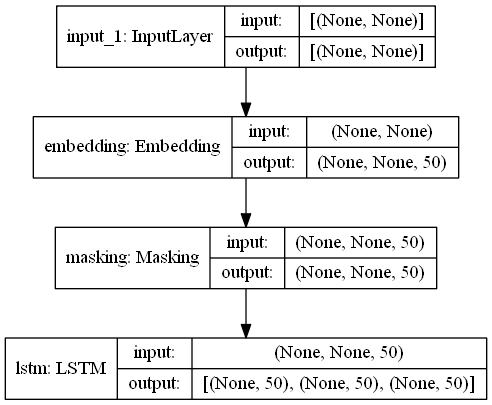

In [32]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)
keras.utils.plot_model(encoder_model, "encoder_model.png", show_shapes=True)

디코더를 설계합니다.

In [33]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

디코더를 정의합니다.

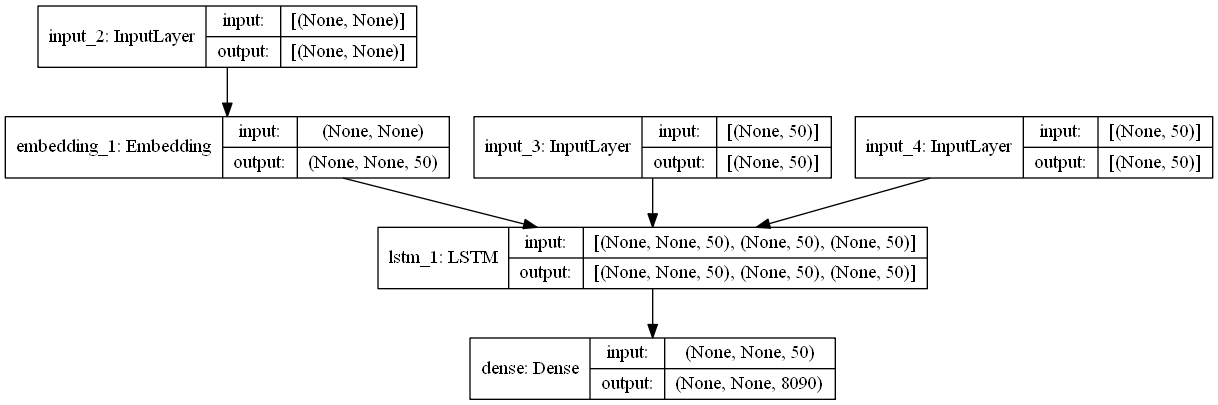

In [34]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)
keras.utils.plot_model(decoder_model, "decoder_model.png", show_shapes=True)

테스트 과정을 위한 모델 설계를 완료하였습니다. 이제 테스트 과정에서의 동작을 위한 decode_sequence 함수를 구현합니다.

In [35]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

결과 확인을 위한 함수를 만듭니다.

In [36]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

훈련 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력해봅시다.

In [37]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_train[seq_index]))
  print("번역문 :",seq2tar(decoder_input_train[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  i can t give up . 
번역문 : je ne parviens pas a admettre ma defaite . 
예측문 :  je ne peux pas pas . 


원문 :  they ll negotiate . 
번역문 : ils negocieront . 
예측문 :  ils sont . 


원문 :  you ve done enough . 
번역문 : vous en avez fait assez . 
예측문 :  vous etes tres . 


원문 :  i m in training . 
번역문 : je suis en formation . 
예측문 :  je suis en train de l . 


원문 :  i felt cheated . 
번역문 : je me sentis trahi . 
예측문 :  je me suis en train de l . 




테스트 데이터에 대해서 임의로 선택한 인덱스의 샘플의 결과를 출력해봅시다.

In [38]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_test[seq_index]))
  print("번역문 :",seq2tar(decoder_input_test[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  did you check this ? 
번역문 : avez vous verifie ceci ? 
예측문 :  etes vous que tu es ? 


원문 :  i have a spare key . 
번역문 : j ai un double des cles . 
예측문 :  je me suis un air . 


원문 :  get on the bus . 
번역문 : monte dans le bus ! 
예측문 :  arrete de l a la voiture ! 


원문 :  it s not that cold . 
번역문 : il ne fait pas si froid . 
예측문 :  il n est pas un maison . 


원문 :  did you write that ? 
번역문 : as tu ecrit ca ? 
예측문 :  etes vous ? 




## 3) 간단한 seq2seq 만들기(Simple seq2seq)

앞서 구현한 seq2seq 모델은 지금까지 만든 모델 중에서 가장 복잡한 모델이었습니다. 아직은 함수형 API의 사용이 부담스러운 분들을 위해 여기서는 좀 더 단순하고 구현이 간단한 seq2seq를 만들면서 seq2seq의 아키텍처 개념을 이해해보겠습니다.

### 1. 간단한 Seq2Seq(Simple Sequnece-to-Sequence)

이번 seq2seq는 보다 단순한 모델이지만 seq2seq의 아이디어는 그대로입니다. 인코더는 입력 시퀀스로부터 정보를 압축한 벡터를 생성하고, 디코더는 이 벡터를 전달받아 출력 시퀀스를 만들어냅니다. 그리고 입력 시퀀스와 출력 시퀀스의 길이는 다를 수 있습니다.

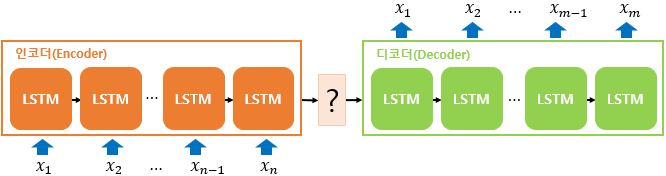

위의 그림은 인코더가 길이 n의 입력 시퀀스를 입력받아 어떤 의문의 벡터 ?에 입력 정보를 압축하고, 디코더가 이 벡터를 전달받아 길이 m의 출력 시퀀스를 만드는 것을 보여줍니다. 그렇다면 여기서 인코더가 디코더에게 전달해주는 벡터의 정체는 무엇일까요?

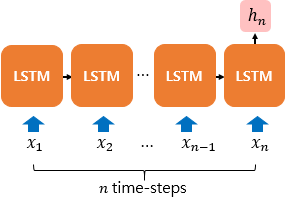

이번에도 인코더가 디코더에게 전달할 벡터는 인코더 LSTM 셀의 마지막 시점(time step)의 은닉 상태(hidden state)입니다. n번째 시점의 은닉 상태는 입력 시퀀스의 정보들을 반영하고 있습니다. 앞서 이 원리를 사용하여 텍스트 분류 문제를 풀었었고, 앞서 배운 seq2seq에서도 이를 디코더에게 전달하는 벡터로 사용했습니다. 그런데 이번에는 디코더로의 전달 방식이 다릅니다.

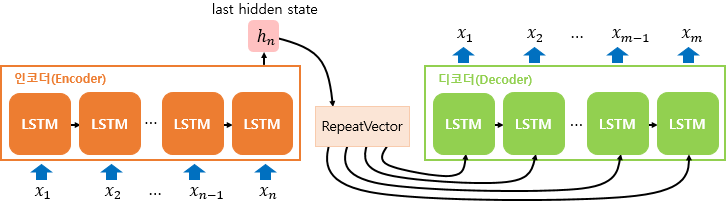

이번에는 인코더의 마지막 은닉 상태를 디코더의 모든 시점의 입력으로 사용합니다. 그리고 이를 위해 입력을 원하는만큼 반복해서 사용하게 해주는 도구인 RepeatVector()를 사용합니다. 이게 이 구조의 전부입니다. 위의 그림은 RepeatVector()를 사용해서 만든 seq2seq를 보여줍니다. 구조가 간단한만큼 코드도 굉장히 간단해집니다. 코드의 형식은 아래와 같습니다.

In [ ]:
model = Sequential()
model.add(LSTM(..., input_shape=(...))) # 인코더
model.add(RepeatVector(...))
model.add(LSTM(..., return_sequences=True)) # 디코더
model.add(TimeDistributed(Dense(...)))

앞서 배운 seq2seq 코드에 비하면 굉장히 간단해졌습니다. 이 구조를 사용한 실습은 향후 추가 예정입니다.